# Finding Similar Shoes Using Vector Search in Db2

In [1]:
import pandas as pd
import random
from faker import Faker
import os
from dotenv import dotenv_values, load_dotenv
from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models import Embeddings
import csv
from IPython.display import Image, display
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import ast
import matplotlib.image as mpimg
from utils import *
pd.set_option('display.max_colwidth', None)  # Show full column content

# Enable Db2 Magic Commands Extensions for Jupyter Notebook
if not os.path.isfile('db2.ipynb'):
    os.system('wget https://raw.githubusercontent.com/IBM/db2-jupyter/master/db2.ipynb')

%run db2.ipynb

Db2 Extensions Loaded. Version: 2024-09-16


<>:1708: SyntaxWarning: invalid escape sequence '\s'
<>:2305: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipykernel_32259/2299624180.py:1708: SyntaxWarning: invalid escape sequence '\s'
  firstCommand = "(?:^\s*)([a-zA-Z]+)(?:\s+.*|$)"
/tmp/ipykernel_32259/2299624180.py:2305: SyntaxWarning: invalid escape sequence '\?'
  pattern = "\?\*[0-9]+"


## Setting up wx.ai API for embedding generation

In [2]:
load_dotenv(os.getcwd()+"/.env", override=True)

credentials = Credentials(
                url = "https://us-south.ml.cloud.ibm.com",
                api_key = os.getenv("WATSONX_APIKEY", "")
                )

client = APIClient(credentials)

project_id = os.getenv("WATSONX_PROJECT", "")
client.set.default_project(project_id)

embeddings = Embeddings(
    model_id=client.foundation_models.EmbeddingModels.MULTILINGUAL_E5_LARGE,
    credentials=credentials,
    project_id=project_id,
)

## Setting up Db2 Connection

In [3]:
db2creds = dotenv_values('.env')
%sql CONNECT CREDENTIALS db2creds

Connection successful. tpcds @ localhost 


# Setting up a Shoes Table at Db2

In [4]:
%sql DROP TABLE SQ_SHOES

# Create the table
sql = get_create_sq_shoes_table_sql()
%sql {sql}

Command completed.
Command completed.


In [5]:
%%capture output
sql = f'''"IMPORT FROM 'shoes-vectors.csv' OF DEL skipcount 1 INSERT INTO SQ_SHOES"'''
_ = ! db2 "connect to TPCDS"

output = %system db2 {sql}
print(output)

## Searching for a Running Shoe of Size `12`, for `Men`

In [6]:
%sql SELECT count(*) FROM SQ_SHOES

,1
0,500


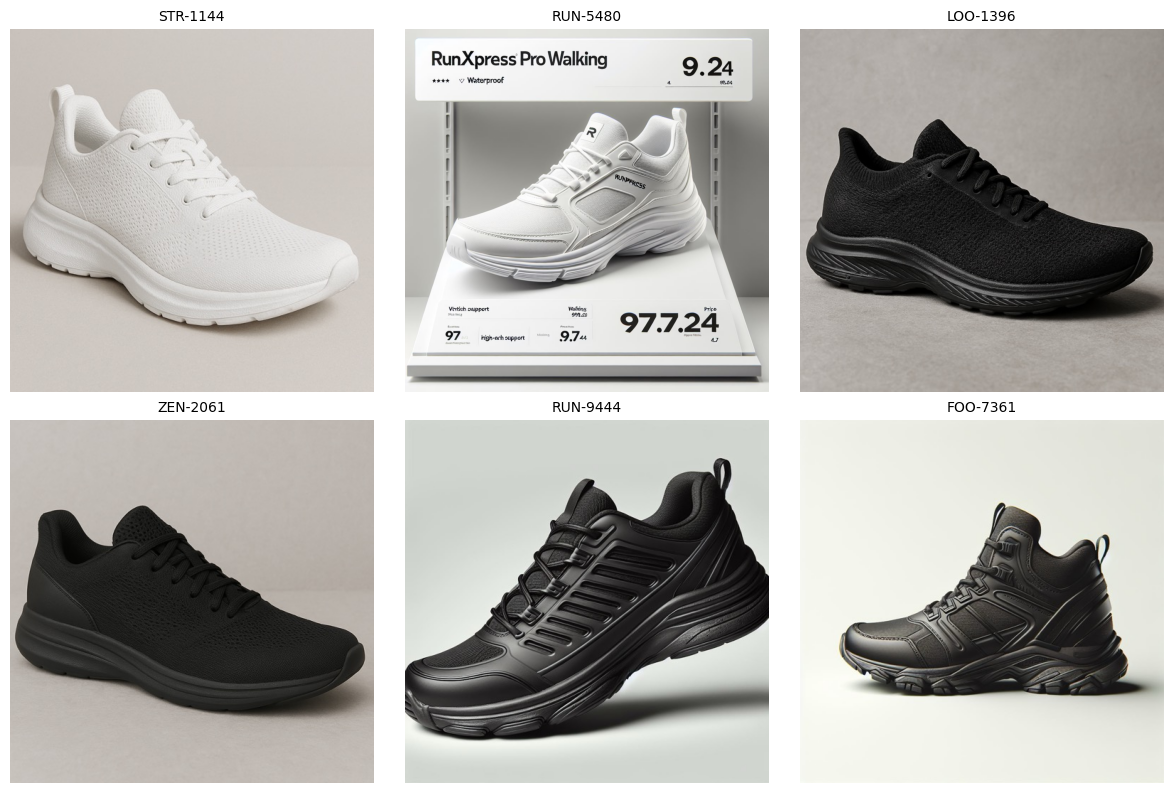

,SKU,PRODUCT_NAME,BRAND,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT,PRICE,RATING,CITY
0,STR-1144,StrideOne Max Running,StrideOne,Running,Knit,White,Waterproof,High,98.13,3.4,Ottawa
1,RUN-5480,RunXpress Pro Walking,RunXpress,Walking,Knit,White,Waterproof,High,97.24,4.7,Toronto
2,LOO-1396,Loopic Pro Running,Loopic,Running,Knit,Black,Resistant,Flat,43.98,4.6,Toronto
3,ZEN-2061,Zentrax Flex Running,Zentrax,Running,Knit,Black,Waterproof,Flat,134.65,4.9,Ottawa
4,RUN-9444,RunXpress X Running,RunXpress,Running,Synthetic,Black,Waterproof,Flat,106.10,3.6,Ottawa
5,FOO-7361,FootFlex Pro Running,FootFlex,Running,Synthetic,Black,Waterproof,High,83.21,4.8,Ottawa


In [7]:
sql = get_men_shoes_sql()
df_shoe_search = %sql {sql}

sku_list = df_shoe_search['SKU'].tolist()
display_sku_images(sku_list)

df_shoe_search.head(6)

### My chosen shoe is available at the Ottawa location

In [8]:
my_choice_sku = 'ZEN-2061'

## Searching for a similar shoes at the Toronto Location

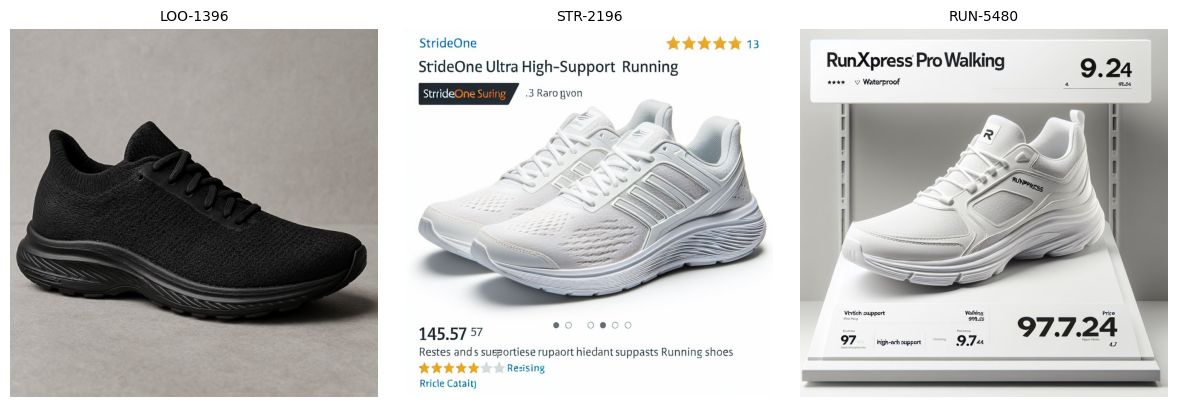

,SKU,PRODUCT_NAME,BRAND,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT,PRICE,RATING,DISTANCE
0,LOO-1396,Loopic Pro Running,Loopic,Running,Knit,Black,Resistant,Flat,43.98,4.6,0.135494
1,STR-2196,StrideOne Ultra Running,StrideOne,Running,Knit,White,Resistant,High,145.57,3.7,0.276512
2,RUN-5480,RunXpress Pro Walking,RunXpress,Walking,Knit,White,Waterproof,High,97.24,4.7,0.295729


In [9]:
sql = get_similar_shoes_sql()
df_shoes_results = %sql {sql}
sku_list = df_shoes_results['SKU'].tolist()

display_sku_images(sku_list)
df_shoes_results.head(3)

## Comparing the Search Results with my Preferred Shoe

In [10]:
sku_list = df_shoes_results.iloc[[0, 2]]['SKU'].tolist()
sku_list.append(my_choice_sku)

sku_sql_in = ', '.join(f"'{sku}'" for sku in sku_list)

sql = get_distance_for_sku_list_sql(sku_sql_in)

df_result = %sql {sql}

cols_show = ['SKU', 'TYPE', 'MATERIAL', 'COLOR', 'WEATHER_RESISTANCE', 'ARCH_SUPPORT']
df_result[cols_show].transpose()

,0,1,2
SKU,ZEN-2061,LOO-1396,RUN-5480
TYPE,Running,Running,Walking
MATERIAL,Knit,Knit,Knit
COLOR,Black,Black,White
WEATHER_RESISTANCE,Waterproof,Resistant,Waterproof
ARCH_SUPPORT,Flat,Flat,High


## Looking under the hood

### 1. original table without a `VECTOR` column

In [11]:
%sql DROP TABLE SQ_SHOES

# Create the table
sql = get_create_sq_shoes_table_data_only()
%sql {sql}

sql = f'''"IMPORT FROM 'shoes.csv' OF DEL skipcount 1 INSERT INTO SQ_SHOES"'''
_ = ! db2 "connect to TPCDS"

output = %system db2 {sql}

%sql SELECT * FROM SQ_SHOES FETCH FIRST 3 ROWS ONLY

Command completed.
Command completed.


,SKU,PRODUCT_NAME,BRAND,CLASS,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT,SIZE,PRICE,RATING,STORE_ID,CITY
0,ZEN-5999,Zentrax X Walking,Zentrax,Women,Walking,Synthetic,White,Resistant,High,8.0,108.65,4.3,1,Ottawa
1,RUN-4723,RunXpress Max Walking,RunXpress,Women,Walking,Synthetic,White,Waterproof,High,8.5,103.22,3.0,20,Ottawa
2,ZEN-8968,Zentrax Pro Running,Zentrax,Men,Running,Synthetic,Black,Waterproof,High,7.5,100.25,3.7,13,Toronto


### 2. Adding a `VECTOR` column

In [12]:
%%sql
ALTER TABLE SQ_SHOES
ADD COLUMN EMBEDDING VECTOR(1024, FLOAT32);

Command completed.


In [13]:
sql = f'''"DESCRIBE TABLE SQ_SHOES"'''
_ = ! db2 "connect to TPCDS"

%system db2 {sql}

['',
 '                                Data type                     Column',
 'Column name                     schema    Data type name      Length     Scale Nulls',
 '------------------------------- --------- ------------------- ---------- ----- ------',
 'SKU                             SYSIBM    VARCHAR                      8     0 Yes   ',
 'PRODUCT_NAME                    SYSIBM    VARCHAR                     23     0 Yes   ',
 'BRAND                           SYSIBM    VARCHAR                      9     0 Yes   ',
 'CLASS                           SYSIBM    VARCHAR                      5     0 Yes   ',
 'TYPE                            SYSIBM    VARCHAR                      7     0 Yes   ',
 'MATERIAL                        SYSIBM    VARCHAR                      9     0 Yes   ',
 'COLOR                           SYSIBM    VARCHAR                      5     0 Yes   ',
 'WEATHER_RESISTANCE              SYSIBM    VARCHAR                     10     0 Yes   ',
 'ARCH_SUPPORT         

In [14]:
%sql SELECT * FROM SQ_SHOES FETCH FIRST 3 ROWS ONLY

,SKU,PRODUCT_NAME,BRAND,CLASS,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT,SIZE,PRICE,RATING,STORE_ID,CITY,EMBEDDING
0,ZEN-5999,Zentrax X Walking,Zentrax,Women,Walking,Synthetic,White,Resistant,High,8.0,108.65,4.3,1,Ottawa,<NA>
1,RUN-4723,RunXpress Max Walking,RunXpress,Women,Walking,Synthetic,White,Waterproof,High,8.5,103.22,3.0,20,Ottawa,<NA>
2,ZEN-8968,Zentrax Pro Running,Zentrax,Men,Running,Synthetic,Black,Waterproof,High,7.5,100.25,3.7,13,Toronto,<NA>


### 1. selected shoe features for generating shoe vectors

In [15]:
embedding_cols = ['TYPE', 'MATERIAL', 'COLOR', 'WEATHER_RESISTANCE', 'ARCH_SUPPORT']
shoe_sample = %sql SELECT * FROM SQ_SHOES WHERE SKU = :my_choice_sku
shoe_sample[embedding_cols]

,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT
0,Running,Knit,Black,Waterproof,Flat


### 2. combined the text features of each shoe as follows

In [16]:
# Combine all columns into a single string for each row, including column names
shoe_sample['combined'] = shoe_sample.apply(
    lambda row: ' [SEP] '.join([f"{col_name}: {row[col_name]}" for col_name in embedding_cols]), 
    axis=1
)

shoe_sample.iloc[0]['combined']

'TYPE: Running [SEP] MATERIAL: Knit [SEP] COLOR: Black [SEP] WEATHER_RESISTANCE: Waterproof [SEP] ARCH_SUPPORT: Flat'

### 3. generated embedding vectors for the shoe text obtained in the previous step. For generating embedding vectors, used `watsonx.ai`

In [17]:

row_combined = shoe_sample['combined'].tolist()
print('input text: ', row_combined[0])

shoe_vectors = embeddings.embed_documents(texts=row_combined)
print('generated embedding vector: ', shoe_vectors[0])

shoe_sample['embedding'] = shoe_vectors
shoe_sample['embedding'] = shoe_sample['embedding'].apply(lambda x: '[' + ', '.join(map(str, x)) + ']')

input text:  TYPE: Running [SEP] MATERIAL: Knit [SEP] COLOR: Black [SEP] WEATHER_RESISTANCE: Waterproof [SEP] ARCH_SUPPORT: Flat
generated embedding vector:  [0.018356532, 0.016739532, -0.043080304, -0.024207275, 0.024635633, -0.04653779, -0.039383117, 0.067312725, 0.04778032, -0.008429668, 0.04462195, 0.02995529, -0.025633719, 0.011672391, -0.030393964, -0.0029873757, -0.03703966, 0.036439303, 0.044415813, -0.029581932, 0.042920265, -0.011383696, -0.04923202, -0.033802535, -0.018248053, -0.010518033, -0.036249846, -0.03555203, -0.006186654, -0.031357873, -0.0007059911, 0.0062761037, -0.024753371, -0.028718058, -0.058127377, 0.0048069307, 0.035525076, 0.045073558, -0.040165797, 0.027472366, -0.037680116, 0.07650787, 0.002180276, -0.013313014, 0.0066697826, 0.025946569, 0.04761589, -0.017814677, -0.013444244, 0.021717995, 0.045873262, 0.015344814, -0.03655906, -0.03055815, -0.030357162, 0.033440053, -0.011115993, 0.0013662616, -0.025815329, 0.007793427, -0.023909122, 0.0062568327, 0.031

### 4. stored vectors in Db2 in a Vector column

In [18]:
%sql SELECT EMBEDDING FROM SQ_SHOES WHERE SKU = :my_choice_sku

,EMBEDDING
0,<NA>


In [19]:
update_sql = f""" 
UPDATE SQ_SHOES SET EMBEDDING = VECTOR('{shoe_vectors[0]}', 1024, FLOAT32) WHERE SKU = :my_choice_sku
"""

%sql {update_sql}

Command completed.


In [20]:
%sql SELECT EMBEDDING FROM SQ_SHOES WHERE SKU = :my_choice_sku

EMBEDDING
0  [0.0183565319,0.0167395324,-0.0430803038,-0.0242072754,0.0246356335,-0.0465377904,-0.0393831171,0.0673127249,0.04778032,-0.00842966791,0.0446219482,0.0299552903,-0.0256337188,0.0116723906,-0.0303939637,-0.00298737572,-0.0370396599,0.0364393033,0.0444158129,-0.0295819324,0.0429202653,-0.0113836965,-0.049232021,-0.0338025354,-0.0182480533,-0.0105180331,-0.0362498462,-0.0355520286,-0.00618665386,-0.0313578732,-0.000705991115,0.00627610367,-0.0247533713,-0.028718058,-0.0581273772,0.00480693066,0.0355250761,0.0450735576,-0.0401657969,0.0274723656,-0.0376801156,0.0765078664,0.00218027597,-0.0133130141,0.00666978257,0.0259465687,0.0476158895,-0.0178146772,-0.0134442439,0.0217179954,0.045873262,0.0153448144,-0.0365590602,-0.0305581503,-0.0303571615,0.0334400535,-0.0111159934,0.00136626163,-0.0258153286,0.00779342698,-0.0239091218,0.00625683274,0.0318220407,-0.0166622587,-0.0375186726,0.0163221527,0.0100017507,0.0037034906,-0.0687411726,0.0163990036,-0.0312115867,0.0342058986,-0.00520346733,-0.012294922,-0.0148840956,-0.0453496873,0.0133561715,-0.00400742143,0.00700843753,-0.00188563694,0.0589920022,-0.0147546893,0.0204682127,5.32398299E-05,0.0133095328,0.00330086215,0.0438726619,0.0363129117,0.0282707307,0.0174393281,0.00625337614,0.0608041808,0.0177331828,-0.0445886552,-0.0372746326,0.0245793983,0.0414964743,0.0170273222,0.0365825817,0.0184044782,-0.0287377834,-0.0292587373,0.0184027962,-0.0261025038,-0.0292409267,0.00344749377,0.0239465609,0.0303817131,0.0231855884,-0.00686943065,0.0329980291,0.0487957411,0.00899011549,-0.0242521968,-0.0201162416,0.00255324179,0.000139396536,-0.0161138792,-0.0205740146,0.0304776095,0.0132281864,0.035088364,0.00383749115,-0.0331088938,0.0439922214,-0.0113768419,-0.000923742366,0.0453349836,0.0121778306,0.0628788397,0.012377942,0.017395081,-0.0245992262,-0.0153914392,-0.0276998356,-0.0373463333,-0.0110083623,-0.00523787877,-0.0235743728,0.0289132819,-0.00525181321,0.0363503508,0.0382898562,-0.0333698317,-0.0147176599,-0.0314672105,-0.0603313334,-0.0107384482,-0.0241461284,-0.0118526947,0.00830769446,-0.00894414634,-0.00899917539,0.0304925572,0.0133582437,-0.0116417659,0.017579468,0.0648465678,0.0141069554,-0.0078127915,-0.0605436787,-0.0431070626,-0.00404952141,-0.012238848,0.00602632435,-0.0384843983,0.0445527025,0.0312450007,0.0145811951,-0.0292477924,-0.0284834988,-0.0491413996,0.0505832694,-0.0512868613,0.0220840182,0.0273729097,0.0355371758,-0.000930469425,0.0579898246,-0.0578518696,-0.00112725119,0.0297327302,0.0491656624,-0.0271069072,-0.039722953,0.0256304741,0.0582840741,0.0289532058,0.0357757807,0.0353515036,0.014288987,-0.000803580682,-0.0182505827,0.000278322404,-0.0197693426,0.00999512337,0.0236391239,-0.00966251083,-0.0488762893,-0.0301080234,0.00125970109,0.0100988988,-0.0176492445,0.0220219325,0.00838383567,-0.00840584841,-0.0598398745,-0.0201809071,0.00928243995,-0.0673591122,-0.0911979452,-0.0184134841,0.041689977,0.0486610085,-0.0263674054,-0.0497061498,-0.0416744873,-0.0263236165,0.0374251083,-0.0171272475,0.0247547347,0.0952240899,-0.00855156779,0.00242021657,-0.00221161428,0.0393689387,0.037348181,0.0237581339,-0.0139055131,0.0114682503,0.0028875526,0.0503912158,-0.055184789,-0.022015715,0.015654685,-0.0291226376,-0.0323178805,-0.0314496383,0.0166449063,0.0157552008,-0.00104593742,0.00811233371,0.0436091349,-0.0161950458,-0.0179945435,-0.0178824309,-0.0122253289,-0.012996776,0.0296779852,-0.0223863311,0.0408646427,0.0435238406,-0.0352738872,0.0141667398,-0.00163814623,0.0235945359,0.0433702283,-0.00577548891,-0.0054696193,0.000585509348,0.023840202,0.0341546014,-0.0141451824,0.00892857928,-0.000800943817,-0.0114409067,0.00553971482,-0.0294306949,-0.0108297383,-0.0549365543,-0.0428965092,-0.0129870931,-0.0468010455,-0.00719659543,-0.0323963761,0.0204620957,-0.0335418656,-0.0159922596,0.00597968744,0.000671550399,-0.00133401609,0.0171622206,0.0100493263,-0.0142394546,-0.0114144664,-0.0145134646,0.0452468172,-0.0159679838,0.00956409052,-0.0121159311,0.000234175677,-0.04

### 5. Loading the vectors of all the shoes - to save demo time

In [21]:
%sql DROP TABLE SQ_SHOES

# Create the table
sql = get_create_sq_shoes_table_sql()
%sql {sql}

sql = f'''"IMPORT FROM 'shoes-vectors.csv' OF DEL skipcount 1 INSERT INTO SQ_SHOES"'''
_ = ! db2 "connect to TPCDS"

output = %system db2 {sql}

Command completed.
Command completed.


### 6. Finding matching shoes using the `VECTOR_DISTANCE` function

In [22]:
sql = f"""
SELECT 
    SKU, 
    PRODUCT_NAME, 
    BRAND, 
    TYPE, 
    MATERIAL, 
    COLOR, 
    WEATHER_RESISTANCE, 
    ARCH_SUPPORT, 
    PRICE, 
    RATING,
    VECTOR_DISTANCE(
        (SELECT EMBEDDING FROM SQ_SHOES WHERE SKU = :my_choice_sku), 
        EMBEDDING, 
        EUCLIDEAN
    ) AS DISTANCE
FROM 
    SQ_SHOES
WHERE 
    SKU <> :my_choice_sku
    AND CITY = 'Toronto'
    AND SIZE = 12
    AND CLASS = 'Men'
ORDER BY 
    DISTANCE ASC
FETCH FIRST 5 ROWS ONLY
"""

top_shoes = %sql {sql}
top_shoes.head()

,SKU,PRODUCT_NAME,BRAND,TYPE,MATERIAL,COLOR,WEATHER_RESISTANCE,ARCH_SUPPORT,PRICE,RATING,DISTANCE
0,LOO-1396,Loopic Pro Running,Loopic,Running,Knit,Black,Resistant,Flat,43.98,4.6,0.135494
1,STR-2196,StrideOne Ultra Running,StrideOne,Running,Knit,White,Resistant,High,145.57,3.7,0.276512
2,RUN-5480,RunXpress Pro Walking,RunXpress,Walking,Knit,White,Waterproof,High,97.24,4.7,0.295729
3,STR-2507,StrideOne Max Running,StrideOne,Running,Synthetic,White,Waterproof,High,123.49,4.5,0.306206
4,STR-7223,StrideOne Max Walking,StrideOne,Walking,Synthetic,White,Resistant,High,130.03,3.9,0.372026


### 7. Visualizing vector search

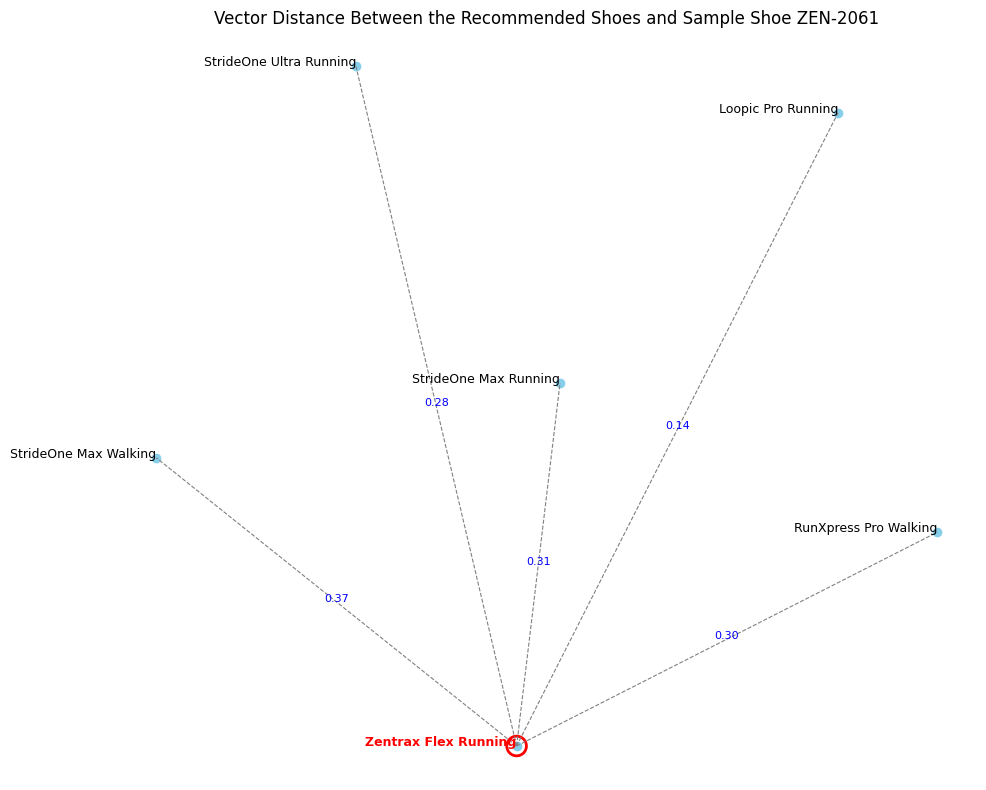

In [23]:

sku_list = top_shoes['SKU'].tolist()
sku_list.append(my_choice_sku)
sku_sql_in = ', '.join(f"'{sku}'" for sku in sku_list)
sql = get_similarity_query(sku_sql_in)

top_matching_vectors = %sql {sql}

plot_similarity_tsne(top_matching_vectors, my_choice_sku)

In [24]:
%sql DROP TABLE SQ_SHOES

Command completed.


In [25]:
%sql CONNECT RESET

Connection closed.
